<a href="https://colab.research.google.com/github/IvanKatorgin/Workshops-and-hackathons/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BE%D1%82_%D0%BA%D0%BE%D0%BC%D0%BF%D0%B0%D0%BD%D0%B8%D0%B8_%D0%9C%D0%BE%D0%BA%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Тестовое задание от компании Мокка

##Описание задания:

В файле revo_ds_test_task.csv собраны данные по повторным займам текущих клиентов компании.

По имеющемуся набору данных, необходимо:
1. построить модель, которая будет прогнозировать значение целевой переменной bad_flag
2. подготовить небольшую презентацию (1-2 слайда), в которой аргументируется выбор модели и показан предполагаемый уровень дефолтности при различных уровнях одобрения

In [1]:
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt, seaborn as sns, xgboost, sklearn.metrics
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('revo_ds_test_task.csv')

In [3]:
data.head()

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,...,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaN,3.0,region_6,6,...,10,0,0,0,10.0,NaN,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,...,6,0,0,0,5.0,NaN,NaN,20.0,False,0
2,779736,2016-10-30,2015-12-21,NaN,NaN,NaN,NaN,2.0,region_1,6,...,0,5,0,0,5.0,NaN,NaN,19.0,False,0
3,556376,2016-06-29,2015-06-30,NaN,NaN,NaN,NaN,1.0,region_6,14,...,4,0,0,0,6.0,NaN,NaN,21.0,False,0
4,266968,2015-12-01,2015-08-03,NaN,NaN,NaN,NaN,0.0,region_5,22,...,0,0,0,0,3.0,NaN,NaN,33.0,False,0


In [4]:
data.shape

(4157, 22)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loanKey              4157 non-null   int64  
 1   rep_loan_date        4157 non-null   object 
 2   first_loan           4157 non-null   object 
 3   dpd_5_cnt            675 non-null    float64
 4   dpd_15_cnt           675 non-null    float64
 5   dpd_30_cnt           675 non-null    float64
 6   first_overdue_date   675 non-null    object 
 7   close_loans_cnt      4142 non-null   float64
 8   federal_district_nm  4146 non-null   object 
 9   TraderKey            4157 non-null   int64  
 10  payment_type_0       4157 non-null   int64  
 11  payment_type_1       4157 non-null   int64  
 12  payment_type_2       4157 non-null   int64  
 13  payment_type_3       4157 non-null   int64  
 14  payment_type_4       4157 non-null   int64  
 15  payment_type_5       4157 non-null   i

In [6]:
data.describe()

,loanKey,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,bad_flag
count,4157.000000,675.000000,675.000000,675.000000,4142.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.0,3909.000000,3507.000000,239.000000,4157.000000,4157.000000
mean,525386.651431,1.444444,0.733333,0.280000,1.184693,12.338225,0.018523,0.596103,3.755834,0.758239,0.019485,0.0,4.979023,578.911345,552.546610,34.561222,0.100313
std,202001.338206,0.900599,0.764572,0.502339,1.723715,9.902927,0.330359,2.564887,3.810703,2.212487,0.245960,0.0,3.491556,48.989869,21.492840,10.834143,0.300453
min,58567.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,384.220628,485.874267,18.000000,0.000000
25%,363964.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,2.000000,547.429791,535.545724,26.000000,0.000000
50%,543603.000000,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,4.000000,588.531315,556.757944,32.000000,0.000000
75%,687271.000000,2.000000,1.000000,1.000000,2.000000,14.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.0,6.000000,612.323090,567.608057,41.000000,0.000000
max,884377.000000,7.000000,5.000000,3.000000,31.000000,80.000000,15.000000,81.000000,33.000000,35.000000,7.000000,0.0,21.000000,691.528420,603.311653,74.000000,1.000000


In [7]:
# посмотрим на пропуски
print(data.isnull().sum())

loanKey                   0
rep_loan_date             0
first_loan                0
dpd_5_cnt              3482
dpd_15_cnt             3482
dpd_30_cnt             3482
first_overdue_date     3482
close_loans_cnt          15
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt       248
score_1                 650
score_2                3918
age                       0
gender                    0
bad_flag                  0
dtype: int64


In [8]:
data.close_loans_cnt.fillna(data.close_loans_cnt.mean(), inplace=True)
data.past_billings_cnt.fillna(0, inplace=True)
# Count the number of NaN values in each column
print(data.isnull().sum())

loanKey                   0
rep_loan_date             0
first_loan                0
dpd_5_cnt              3482
dpd_15_cnt             3482
dpd_30_cnt             3482
first_overdue_date     3482
close_loans_cnt           0
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt         0
score_1                 650
score_2                3918
age                       0
gender                    0
bad_flag                  0
dtype: int64


In [9]:
data["rep_loan_date"] = pd.to_datetime(data["rep_loan_date"])
data["first_loan"] = pd.to_datetime(data["first_loan"])
data["first_overdue_date"] = pd.to_datetime(data["first_overdue_date"])
data["TraderKey"] = pd.to_numeric(data["TraderKey"], downcast='signed')
data["past_billings_cnt"] = data["past_billings_cnt"].astype(int)
data["age"] = data["age"].astype(int)
data['federal_district_nm'] = data['federal_district_nm'].astype('category')

In [10]:
data['first_loan_year']= data['first_loan'].apply(lambda x: x.year)
data['first_loan_month'] = data['first_loan'].apply(lambda x: x.month)
data['first_loan_day'] = data['first_loan'].apply(lambda x: x.day)

data['rep_loan_date_year']= data['rep_loan_date'].apply(lambda x: x.year)
data['rep_loan_date_month'] = data['rep_loan_date'].apply(lambda x: x.month)
data['rep_loan_date_day'] = data['rep_loan_date'].apply(lambda x: x.day)

data['first_overdue_year']= data['first_overdue_date'].apply(lambda x: x.year)
data['first_overdue_month'] = data['first_overdue_date'].apply(lambda x: x.month)
data['first_overdue_day'] = data['first_overdue_date'].apply(lambda x: x.day)

In [11]:
# Cleaning
list_del =['loanKey']
for i in data.columns:
    if data[i].isnull().sum() == data.shape[0]: # or len(data[i].unique()) < 3
        list_del.append(i)
data.drop(list_del, axis=1, inplace=True)
print('The following columns were deleted:', list_del)

The following columns were deleted: ['loanKey']


In [12]:
from datetime import datetime
data['Difference'] = (data['first_overdue_date'] - data['first_loan']).dt.days
data['Recurrence'] = (data['rep_loan_date'] - data['first_loan']).dt.days

In [13]:
# See the missing values
print(data.isnull().sum())

rep_loan_date             0
first_loan                0
dpd_5_cnt              3482
dpd_15_cnt             3482
dpd_30_cnt             3482
first_overdue_date     3482
close_loans_cnt           0
federal_district_nm      11
TraderKey                 0
payment_type_0            0
payment_type_1            0
payment_type_2            0
payment_type_3            0
payment_type_4            0
payment_type_5            0
past_billings_cnt         0
score_1                 650
score_2                3918
age                       0
gender                    0
bad_flag                  0
first_loan_year           0
first_loan_month          0
first_loan_day            0
rep_loan_date_year        0
rep_loan_date_month       0
rep_loan_date_day         0
first_overdue_year     3482
first_overdue_month    3482
first_overdue_day      3482
Difference             3482
Recurrence                0
dtype: int64


In [14]:
data = data.dropna(how='all')    #to drop if all values in the row are nan
data.shape

(4157, 32)

In [15]:
def create_dummy(column):
    global data
    dummy_ranks = pd.get_dummies(data[column], prefix=column, dtype=bool)
    # Create dummy variables for the regression
    cols_to_keep = list(data.columns.values)
    data = data[cols_to_keep].join(dummy_ranks.loc[:, dummy_ranks.columns[0]:])
    data.drop(column, axis=1, inplace=True)

In [16]:
create_dummy("federal_district_nm")
create_dummy("dpd_5_cnt")
create_dummy("dpd_15_cnt")
create_dummy("dpd_30_cnt")

In [17]:
data["Difference"].fillna(0, inplace=True)
data["first_overdue_year"].fillna(0, inplace=True)
data["first_overdue_month"].fillna(0, inplace=True)
data["first_overdue_day"].fillna(0, inplace=True)

# Balance the dataset

In [18]:
from sklearn.utils import resample
data['bad_flag'].value_counts()

,count
bad_flag,
0,3740
1,417


In [19]:
# Separate majority and minority classes
df_majority = data[data.bad_flag==0]
df_minority = data[data.bad_flag==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=3740,    # to match majority class
                                 random_state=123) # reproducible results

In [20]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.bad_flag.value_counts()

,count
bad_flag,
0,3740
1,3740


In [21]:
from sklearn.utils import shuffle
df_upsampled = shuffle(df_upsampled, random_state=0)

# Splitting the data

In [22]:
columns = df_upsampled.columns.tolist()
columns = [c for c in columns if c not in ["rep_loan_date", 'first_loan', "first_overdue_date",
                                           "bad_flag", "score_1", "score_2", "past_billings_cnt"]]

In [23]:
y = df_upsampled.bad_flag
X_train, X_test, y_train, y_test = train_test_split(df_upsampled[columns], y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5984, 47) (5984,)
(1496, 47) (1496,)


# Logistic regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
model1 = LogisticRegression()
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print("Accuracy for logistic regression: %.2f" % (model1.score(X_test, y_test) * 100))

Accuracy for logistic regression: 68.78


In [25]:
# evaluate the model using 10-fold cross-validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
results = model_selection.cross_val_score(model1, X_train, y_train, cv=10, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()* 100))

10-fold cross validation average accuracy: 66.945


In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred1)
print(confusion_matrix)

[[501 256]
 [211 528]]


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       757
           1       0.67      0.71      0.69       739

    accuracy                           0.69      1496
   macro avg       0.69      0.69      0.69      1496
weighted avg       0.69      0.69      0.69      1496



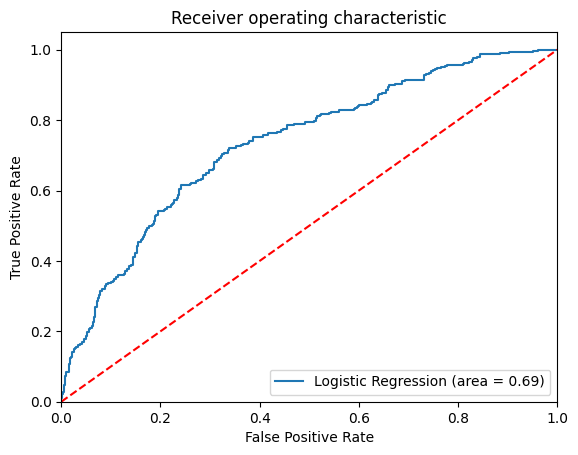

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, model1.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, model1.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Random forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(n_estimators = 100)
model2 = model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print("Accuracy for random forest: %.2f" % (model2.score(X_test, y_test) * 100))

Accuracy for random forest: 99.13


In [30]:
# evaluate the model using 10-fold cross-validation
results = model_selection.cross_val_score(model2, X_train, y_train, cv=10, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()* 100))

10-fold cross validation average accuracy: 98.446


In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred2)
print(confusion_matrix)

[[744  13]
 [  0 739]]


In [32]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       757
           1       0.67      0.71      0.69       739

    accuracy                           0.69      1496
   macro avg       0.69      0.69      0.69      1496
weighted avg       0.69      0.69      0.69      1496



In [33]:
list(zip(X_train, model2.feature_importances_))

[('close_loans_cnt', 0.04869788610650379),
 ('TraderKey', 0.04939246440781039),
 ('payment_type_0', 0.0017686409320258462),
 ('payment_type_1', 0.019209944717736294),
 ('payment_type_2', 0.06052670902565737),
 ('payment_type_3', 0.03256956028047577),
 ('payment_type_4', 0.0014150175544088031),
 ('payment_type_5', 0.0),
 ('age', 0.11608221191370519),
 ('gender', 0.01647813596796862),
 ('first_loan_year', 0.01248526309505488),
 ('first_loan_month', 0.06401377590017546),
 ('first_loan_day', 0.09064123311902623),
 ('rep_loan_date_year', 0.013543055948354265),
 ('rep_loan_date_month', 0.06357017758026301),
 ('rep_loan_date_day', 0.08514405371478809),
 ('first_overdue_year', 0.010673021403114203),
 ('first_overdue_month', 0.01859592297317788),
 ('first_overdue_day', 0.017672225492688456),
 ('Difference', 0.024951073188921705),
 ('Recurrence', 0.1380847533977321),
 ('federal_district_nm_region_0', 0.0075309337104297255),
 ('federal_district_nm_region_1', 0.008102036755060514),
 ('federal_dist

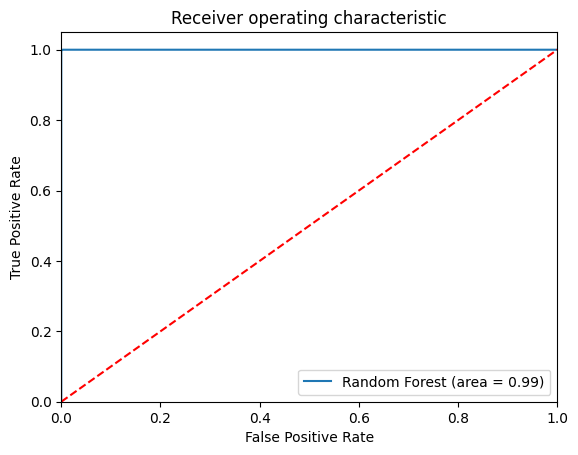

In [34]:
logit_roc_auc2 = roc_auc_score(y_test, model2.predict(X_test))
fpr2, tpr2, thresholds2 = roc_curve(y_test, model2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr2, tpr2, label='Random Forest (area = %0.2f)' % logit_roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Random_Forest_ROC')
plt.show()

# XGboost Classification

In [35]:
model3 = xgboost.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print("Accuracy for XGBoost: %.2f" % (model3.score(X_test, y_test) * 100))

Accuracy for XGBoost: 97.26


In [36]:
# evaluate the model using 10-fold cross-validation
results = model_selection.cross_val_score(model3, X_train, y_train, cv=10, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()* 100))

10-fold cross validation average accuracy: 96.675


In [37]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred3)
print(confusion_matrix)

[[716  41]
 [  0 739]]


In [38]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       757
           1       0.95      1.00      0.97       739

    accuracy                           0.97      1496
   macro avg       0.97      0.97      0.97      1496
weighted avg       0.97      0.97      0.97      1496



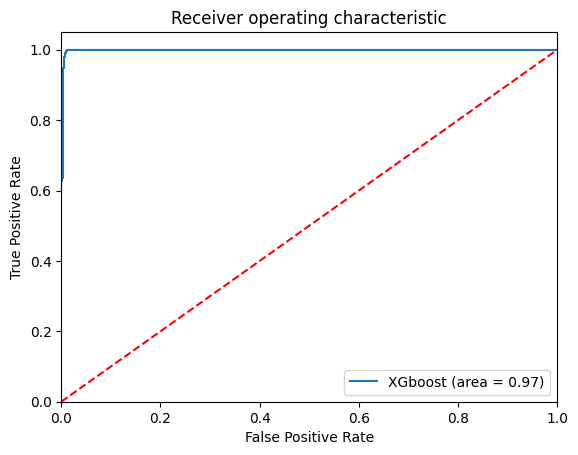

In [39]:
logit_roc_auc3 = roc_auc_score(y_test, model3.predict(X_test))
fpr3, tpr3, thresholds3 = roc_curve(y_test, model3.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr3, tpr3, label='XGboost (area = %0.2f)' % logit_roc_auc3)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGboost_ROC')
plt.show()

# SVM classifier

In [40]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
# Set the parameters to try
# Gaussian radial basis function kernel
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    model4 = svm.SVC()
    model4 = GridSearchCV(model4, tuned_parameters, cv=5, scoring='%s_macro' % score)
    model4.fit(X_train, y_train)

    print("\nBest parameters set found on development set: %r" % (model4.best_params_))
    print("Grid scores on development set:\n")

    means = model4.cv_results_['mean_test_score']
    stds = model4.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model4.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print("\n Detailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")

    y_pred4 = model4.predict(X_test)
    print(classification_report(y_test, y_pred4))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Grid scores on development set:

0.765 (+/-0.007) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.683 (+/-0.014) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.863 (+/-0.007) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.716 (+/-0.010) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.921 (+/-0.004) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.757 (+/-0.026) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.675 (+/-0.020) for {'C': 1, 'kernel': 'linear'}
0.679 (+/-0.040) for {'C': 10, 'kernel': 'linear'}
0.679 (+/-0.041) for {'C': 100, 'kernel': 'linear'}

 Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       757
           1       0.88      0.99      0.93      

In [41]:
from sklearn import svm
#Training with the best parameters: {'C': 1, 'kernel': 'linear'}
model4 = svm.SVC(C = 1000, kernel='rbf', gamma = 0.001, probability=True)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print("Accuracy for support vector classifier: %.2f" % (model4.score(X_test, y_test) * 100))

Accuracy for support vector classifier: 94.25


In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred4)
print(confusion_matrix)

[[671  86]
 [  0 739]]


In [43]:
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       757
           1       0.90      1.00      0.95       739

    accuracy                           0.94      1496
   macro avg       0.95      0.94      0.94      1496
weighted avg       0.95      0.94      0.94      1496



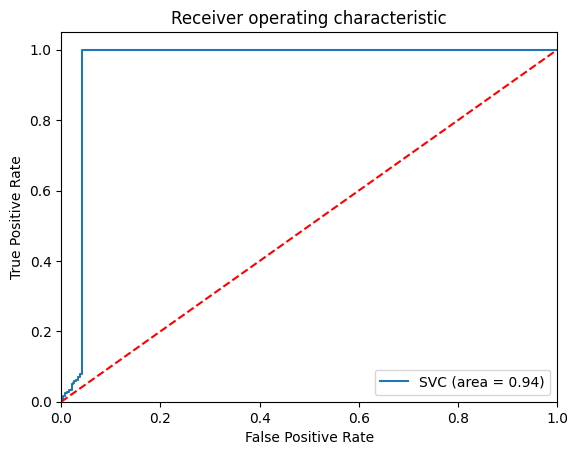

In [44]:
logit_roc_auc4 = roc_auc_score(y_test, model4.predict(X_test))
fpr4, tpr4, thresholds4 = roc_curve(y_test, model4.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr4, tpr4, label='SVC (area = %0.2f)' % logit_roc_auc4)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc = "lower right")
plt.savefig('SVC_ROC')
plt.show()

# Summary

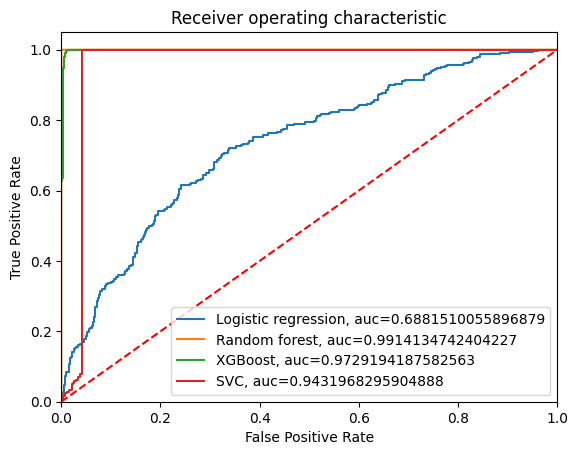

In [45]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr1, tpr1, thresholds1 = roc_curve(y_test, model1.predict_proba(X_test)[:,1])
auc1 = roc_auc_score(y_test, model1.predict(X_test))
plt.plot(fpr1,tpr1,label="Logistic regression, auc="+str(auc1))

pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr2, tpr2, thresholds2 = roc_curve(y_test, model2.predict_proba(X_test)[:,1])
auc2 = roc_auc_score(y_test, model2.predict(X_test))
plt.plot(fpr2,tpr2,label="Random forest, auc="+str(auc2))


pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr3, tpr3, thresholds3 = roc_curve(y_test, model3.predict_proba(X_test)[:,1])
auc3 = roc_auc_score(y_test, model3.predict(X_test))
plt.plot(fpr3,tpr3,label="XGBoost, auc="+str(auc3))


pred = np.random.rand(1000)
label = np.random.randint(2, size=1000)
fpr4, tpr4, thresholds4 = roc_curve(y_test, model4.predict_proba(X_test)[:,1])
auc4 = roc_auc_score(y_test, model4.predict(X_test))
plt.plot(fpr4,tpr4,label="SVC, auc="+str(auc4))


plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Total_ROC')

plt.legend(loc=0)

In [46]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold2):
    print('Sensitivity:', tpr2[thresholds2 > threshold2][-1])
    print('Specificity:', 1 - fpr2[thresholds2 > threshold2][-1])

In [47]:
evaluate_threshold(0.8)
# Sensitivity - true positive rate - defaults correctly identified
# Specificity - false positive rate - good loans correctly identified

Sensitivity: 0.9986468200270636
Specificity: 1.0


In [48]:
evaluate_threshold(0.33)
# Sensitivity - true positive rate - defaults correctly identified
# Specificity - false positive rate - good loans correctly identified

Sensitivity: 1.0
Specificity: 0.8982826948480845


Основные выводы:

В работе построены 4 модели прогнозирования значения целевой переменной bad_flag:
1. Логистическая регрессия
2. Случайный лес
3. XGboost Classification
4. SVC Classification

Наилучшие результаты были получены в модели случайного леса (accuracy 99.13), тогда как логистическая регрессия показала наихудший, из рассмотренных моделей, результат (accuracy 68.78). Модель SVC Classification также не рекомендуется из-за слишком долгого и медленного обучения и реализации.

Модель случайного леса может быть использована в дальнейшем для прогнозирования значения целевой переменной bad_flag.

Теперь создадим слайды для презентации в power point

In [49]:
! pip install python-pptx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 13.1 MB/s eta 0:00:00


In [50]:
from pptx import Presentation
from pptx.util import Inches, Pt  # Импортируем Pt для задания размера шрифта
from pptx.enum.text import PP_ALIGN, MSO_AUTO_SIZE
from pptx.dml.color import RGBColor

In [51]:
# Создаем новую презентацию
prs = Presentation()

In [52]:
# Добавляем слайд с макетом "Заголовок и содержимое"
title_slide_layout = prs.slide_layouts[1] # 1 - это макет "Заголовок и содержимое"
slide = prs.slides.add_slide(title_slide_layout)

In [53]:
# Добавляем заголовок слайда
title = slide.shapes.title
title.text = "Тестовое задание для компании Мокка"

In [54]:
# Получаем объект TextFrame для содержимого слайда
content = slide.shapes.placeholders[1].text_frame

# Очищаем текст по умолчанию (если есть)
content.clear()

# Добавляем первый абзац
paragraph1 = content.add_paragraph()
paragraph1.text = "Задание: Предсказание отказа в кредите"
paragraph1.font.bold = True  # Жирный шрифт
paragraph1.font.size = Pt(18)  # Размер шрифта
paragraph1.font.color.rgb = RGBColor(0, 0, 255)  # Синий цвет текста
paragraph1.font.italic = True  # Курсив
paragraph1.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем второй абзац
paragraph2 = content.add_paragraph()
paragraph2.text = "По имеющемуся набору данных, необходимо построить модель, которая будет прогнозировать значение целевой переменной bad_flag"
paragraph2.font.bold = True  # Жирный шрифт
paragraph2.font.size = Pt(18)  # Размер шрифта
paragraph2.font.color.rgb = RGBColor(0, 0, 255)  # Синий цвет текста
paragraph2.font.italic = True  # Курсив
paragraph2.font.name = 'Times New Roman'  # Шрифт Times New Roman

In [55]:
# добавим еще один слайд
title_slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(title_slide_layout)

In [56]:
# Добавляем заголовок слайда
title = slide.shapes.title
title.text = "Что было сделано и результаты"

In [57]:
# Получаем объект TextFrame для содержимого слайда
content = slide.shapes.placeholders[1].text_frame

# Очищаем текст по умолчанию (если есть)
content.clear()

# Добавляем первый абзац
paragraph1 = content.add_paragraph()
paragraph1.text = "В работе построены следующие модели:"
paragraph1.font.size = Pt(16)  # Размер шрифта
paragraph1.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем второй абзац
paragraph2 = content.add_paragraph()
paragraph2.text = "1. Логистическая регрессия"
paragraph2.font.size = Pt(14)  # Размер шрифта
paragraph2.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем третий абзац
paragraph3 = content.add_paragraph()
paragraph3.text = "2. Случайный лес"
paragraph3.font.size = Pt(14)  # Размер шрифта
paragraph3.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем четвертый абзац
paragraph4 = content.add_paragraph()
paragraph4.text = "3. XGBoost"
paragraph4.font.size = Pt(14)  # Размер шрифта
paragraph4.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем пятый абзац
paragraph5 = content.add_paragraph()
paragraph5.text = "4. SVC"
paragraph5.font.size = Pt(14)  # Размер шрифта
paragraph5.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем шестой абзац
paragraph6 = content.add_paragraph()
paragraph6.text = "Accuracy по моделям составили:"
paragraph6.font.size = Pt(16)  # Размер шрифта
paragraph6.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем седьмой абзац
paragraph7 = content.add_paragraph()
paragraph7.text = "1. Logistic regression: %.2f" % (model1.score(X_test, y_test) * 100)
paragraph7.font.size = Pt(14)
paragraph7.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем восьмой абзац
paragraph8 = content.add_paragraph()
paragraph8.text = "2. Random forest: %.2f" % (model2.score(X_test, y_test) * 100)
paragraph8.font.size = Pt(14)
paragraph8.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем девятый абзац
paragraph9 = content.add_paragraph()
paragraph9.text = "3. XGBoost: %.2f" % (model3.score(X_test, y_test) * 100)
paragraph9.font.size = Pt(14)
paragraph9.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем десятый абзац
paragraph10 = content.add_paragraph()
paragraph10.text = "4. SVC: %.2f" % (model4.score(X_test, y_test) * 100)
paragraph10.font.size = Pt(14)
paragraph10.font.name = 'Times New Roman'  # Шрифт Times New Roman

In [58]:
# добавим еще один слайд
slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(slide_layout)

In [59]:
# Добавляем заголовок слайда
title = slide.shapes.title
title.text = "Визуализируем результаты"

In [60]:
# Получаем объект TextFrame для содержимого слайда
content = slide.shapes.placeholders[1].text_frame

# Добавляем абзац
paragraph = content.add_paragraph()
paragraph.text = "ROC кривая"
paragraph.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем изображение в содержимое слайда
# центрируем изображение
left = Inches(1)
top = Inches(3)
pic = slide.shapes.add_picture('Total_ROC.png', left, top, height=Inches(4))

In [61]:
# добавим еще один слайд
slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(slide_layout)

In [62]:
# Добавляем заголовок слайда
title = slide.shapes.title
title.text = "Основные выводы"

In [63]:
# Получаем объект TextFrame для содержимого слайда
content = slide.shapes.placeholders[1].text_frame

# Добавляем первый абзац
paragraph1 = content.add_paragraph()
paragraph1.text = "1. Наилучшая модель по ROC кривой: случайный лес"
paragraph1.font.size = Pt(16)
paragraph1.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем второй абзац
paragraph2 = content.add_paragraph()
paragraph2.text = "2. Наихудшая модель по ROC кривой: логистическая регрессия"
paragraph2.font.size = Pt(16)
paragraph2.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем третий абзац
paragraph3 = content.add_paragraph()
paragraph3.text = "3. Модель SVC Classification не рекомендуется из-за слишком долгого и медленного обучения и реализации"
paragraph3.font.size = Pt(16)
paragraph3.font.name = 'Times New Roman'  # Шрифт Times New Roman

# Добавляем четвертый абзац
paragraph4 = content.add_paragraph()
paragraph4.text = "4. Модель случайного леса может быть использована в дальнейшем для прогнозирования значения целевой переменной bad_flag"
paragraph4.font.size = Pt(16)
paragraph4.font.name = 'Times New Roman'  # Шрифт Times New Roman

In [64]:
# добавим еще один слайд
slide_layout = prs.slide_layouts[1]
slide = prs.slides.add_slide(slide_layout)

In [65]:
# Размеры слайда (в дюймах)
slide_width = prs.slide_width
slide_height = prs.slide_height

# Текст для центра слайда
center_text = "Спасибо за внимание!"

# Создаем текстовое поле для центрированного текста
center_width = Inches(6)  # Ширина текстового поля
center_height = Inches(1)  # Высота текстового поля
center_left = (slide_width - center_width) / 2  # Центрируем по горизонтали
center_top = (slide_height - center_height) / 2  # Центрируем по вертикали
center_textbox = slide.shapes.add_textbox(center_left, center_top, center_width, center_height)
center_text_frame = center_textbox.text_frame

# Добавляем центрированный текст
center_paragraph = center_text_frame.add_paragraph()
center_paragraph.text = center_text
center_paragraph.font.bold = True
center_paragraph.font.size = Pt(24)
center_paragraph.font.color.rgb = RGBColor(0, 0, 0)  # Черный цвет
center_paragraph.alignment = PP_ALIGN.CENTER  # Выравнивание по горизонтали

# Включаем автоматическое изменение размера текстового поля
center_text_frame.auto_size = MSO_AUTO_SIZE.SHAPE_TO_FIT_TEXT

# Текст для нижней части слайда
bottom_text = "(презентация создана в Python с использованием библиотеки python-pptx)"

# Создаем текстовое поле для текста внизу
bottom_width = Inches(6)  # Ширина текстового поля
bottom_height = Inches(1)  # Высота текстового поля
bottom_left = (slide_width - bottom_width) / 2  # Центрируем по горизонтали
bottom_top = slide_height - bottom_height - Inches(0.5)  # Размещаем внизу с небольшим отступом
bottom_textbox = slide.shapes.add_textbox(bottom_left, bottom_top, bottom_width, bottom_height)
bottom_text_frame = bottom_textbox.text_frame

# Добавляем текст внизу
bottom_paragraph = bottom_text_frame.add_paragraph()
bottom_paragraph.text = bottom_text
bottom_paragraph.font.bold = True
bottom_paragraph.font.size = Pt(14)
bottom_paragraph.font.color.rgb = RGBColor(255, 0, 0)  # Красный цвет
bottom_paragraph.alignment = PP_ALIGN.CENTER  # Выравнивание по горизонтали

# Включаем автоматическое изменение размера текстового поля
bottom_text_frame.auto_size = MSO_AUTO_SIZE.SHAPE_TO_FIT_TEXT

In [66]:
# Сохраняем презентацию
prs.save('Presentation for Mokka.pptx')
print("Презентация создана и сохранена как 'Presentation for Mokka.pptx'")

Презентация создана и сохранена как 'Presentation for Mokka.pptx'
